In [1]:
import numpy as np
import torch

from botorch.utils.multi_objective import is_non_dominated

from ellipse_utils import (
    sample_2d_circle,
    ellipsify,
    get_ellipse_patch,
)

from scipy.spatial import ConvexHull
from scipy.stats import beta

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
num_points = 100
t = np.linspace(-0.5, 1.5, num_points)
num_samples = 2**10
p = 0.5

# Univariate betas.
b1 = beta(3, 2, loc=0, scale=1)
b2 = beta(6, 3, loc=0, scale=0.4)
b3 = beta(1.5, 3, loc=0.6, scale=0.4)

u1_pdf = b1.pdf(t)
u1_cdf = b1.cdf(t)
u1_samples = b1.rvs(num_samples)

u2_pdf = p * b2.pdf(t) + (1 - p) * b3.pdf(t)
u2_cdf = p * b2.cdf(t) + (1 - p) * b3.cdf(t)

n1 = np.sum(np.random.rand(num_samples) < 0.5)
n2 = num_samples - n1
u2_samples = np.concatenate([b2.rvs(n1), b3.rvs(n2)])

u_pdf = [u1_pdf, u2_pdf]
u_cdf = [u1_cdf, u2_cdf]
u_samples = [u1_samples, u2_samples]

# Multivariate ellipses.
num_weights = 2**10
nadir = -torch.ones(2, **tkwargs)
base_samples = sample_2d_circle(n=num_samples, **tkwargs)
unit_vector = UnitVector(num_objectives=2, transform_label="polar")
weights = unit_vector(torch.linspace(0, 1, num_weights).unsqueeze(-1).to(**tkwargs))
s_fn = LengthScalarization(weights=weights, ref_points=nadir)

r1 = torch.tensor([[0.4, 0.2]], **tkwargs)
a1 = [-0.25 * torch.pi]
t1 = 0.5 * torch.ones(1, 2, **tkwargs)
s1 = ellipsify(base_samples, radius=r1[0], angle=a1[0], translate=t1[0])


r2 = torch.tensor(
    [
        [0.2, 0.1],
        [0.1, 0.05],
        [0.075, 0.1],
        [0.2, 0.05],
        [0.15, 0.1],
    ],
    **tkwargs
)

a2 = torch.tensor(
    [
        -0.2 * torch.pi,
        -0.05 * torch.pi,
        0.05 * torch.pi,
        0.0 * torch.pi,
        0.1 * torch.pi,
    ],
    **tkwargs
)
t2 = torch.tensor(
    [
        [0.3, 0.8],
        [0.45, 0.5],
        [0.70, 0.8],
        [0.77, 0.35],
        [0.8, 0.15],
    ],
    **tkwargs
)

areas = torch.zeros(len(r2) + 1, **tkwargs)
for i, r in enumerate(r2):
    areas[i + 1] = torch.pi * torch.prod(r)

indices = torch.cumsum((num_samples * areas / torch.sum(areas)).round(), dim=0)

s2 = []
for i in range(len(r2)):
    base_samples_i = base_samples[int(indices[i]) : int(indices[i + 1])]
    s2.append(ellipsify(base_samples_i, radius=r2[i], angle=a2[i], translate=t2[i]))
s2 = torch.row_stack(s2)

radii = [r1, r2]
angles = [a1, a2]
translates = [t1, t2]
e_samples = [s1, s2]

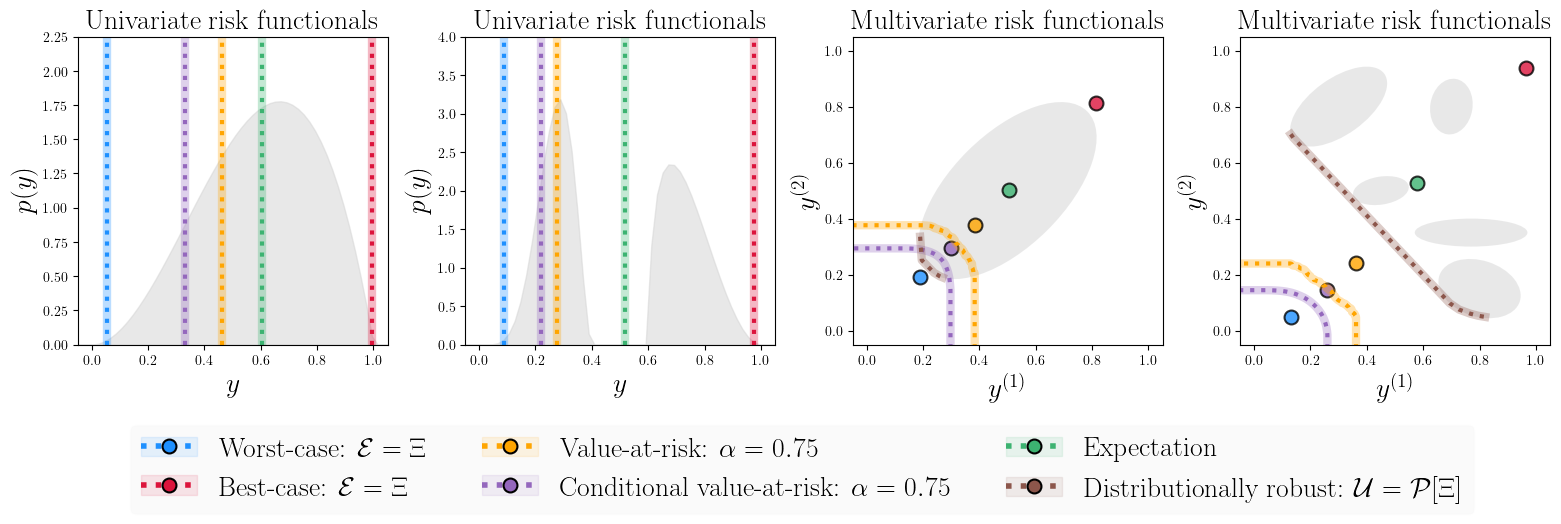

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(19, 4))

q = 1 - 0.75

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.15
)
#########################################################################################
for i in range(2):
    plt.subplot(1, 4, 1 + i)
    samples = u_samples[i]
    pdf = u_pdf[i]
    cdf = u_cdf[i]

    # plt.plot(t, pdf, color="lightgray", linewidth=3, alpha=1)
    plt.fill_between(t, np.zeros(t.shape), pdf, color="lightgray", alpha=0.5)

    plt.axvline(
        samples.mean(), color="mediumseagreen", linestyle="-", linewidth=6, alpha=0.3
    )
    plt.axvline(samples.mean(), color="mediumseagreen", linestyle=":", linewidth=3)

    plt.axvline(
        samples.min(), color="dodgerblue", linestyle="-", linewidth=6, alpha=0.3
    )
    plt.axvline(samples.min(), color="dodgerblue", linestyle=":", linewidth=3)

    plt.axvline(samples.max(), color="crimson", linestyle="-", linewidth=6, alpha=0.3)
    plt.axvline(samples.max(), color="crimson", linestyle=":", linewidth=3)

    quantile = np.quantile(samples, q=q)

    plt.axvline(quantile, color="orange", linestyle="-", linewidth=6, alpha=0.3)
    plt.axvline(quantile, color="orange", linestyle=":", linewidth=3)

    plt.axvline(
        samples[samples < quantile].mean(),
        color="tab:purple",
        linestyle="-",
        linewidth=6,
        alpha=0.3,
    )
    plt.axvline(
        samples[samples < quantile].mean(),
        color="tab:purple",
        linestyle=":",
        linewidth=3,
    )

    plt.xlim(-0.05, 1.05)
    plt.xlabel(r"$y$", fontsize=20)
    plt.ylabel(r"$p(y)$", fontsize=20)
    plt.title("Univariate risk functionals", fontsize=20)
#########################################################################################
for j in range(2):
    ax = plt.subplot(1, 4, 3 + j)
    samples = e_samples[j]
    rad = radii[j]
    ang = angles[j]
    trans = translates[j]

    for i in range(len(rad)):
        ellipse, transform = get_ellipse_patch(
            radius=rad[i],
            angle=ang[i],
            translate=trans[i],
            alpha=0.5,
            facecolor="lightgray",
        )
        ellipse.set_transform(transform + ax.transData)
        ax.add_patch(ellipse)

    sample_mean = samples.mean(dim=0)
    plt.scatter(
        sample_mean[0],
        sample_mean[1],
        color="mediumseagreen",
        marker="o",
        edgecolors="k",
        s=100,
        alpha=0.8,
        linewidth=1.5,
    )

    sample_min = samples.min(dim=0).values
    plt.scatter(
        sample_min[0],
        sample_min[1],
        color="dodgerblue",
        marker="o",
        edgecolors="k",
        s=100,
        alpha=0.8,
        linewidth=1.5,
    )

    sample_max = samples.max(dim=0).values
    plt.scatter(
        sample_max[0],
        sample_max[1],
        color="crimson",
        marker="o",
        edgecolors="k",
        s=100,
        alpha=0.8,
        linewidth=1.5,
    )

    sample_quantile = samples.quantile(q, dim=0)
    plt.scatter(
        sample_quantile[0],
        sample_quantile[1],
        color="orange",
        marker="o",
        edgecolors="k",
        s=100,
        alpha=0.8,
        linewidth=1.5,
    )

    sample_cvar = torch.zeros_like(sample_quantile)
    for i in range(2):
        sample_cvar[i] = samples[:, i][samples[:, i] < sample_quantile[i]].mean()

    plt.scatter(
        sample_cvar[0],
        sample_cvar[1],
        color="tab:purple",
        marker="o",
        edgecolors="k",
        s=100,
        alpha=0.8,
        linewidth=1.5,
    )

    lengths = s_fn(samples)
    quantile_lengths = lengths.quantile(q=q, dim=0)
    quantile_front = nadir + quantile_lengths.unsqueeze(-1) * weights

    cvar_lengths = torch.zeros_like(quantile_lengths)
    for i in range(len(weights)):
        cvar_lengths[i] = lengths[:, i][lengths[:, i] < quantile_lengths[i]].mean()

    cvar_front = nadir + cvar_lengths.unsqueeze(-1) * weights

    plt.plot(
        quantile_front[:, 0],
        quantile_front[:, 1],
        color="orange",
        linestyle="-",
        linewidth=6,
        alpha=0.3,
    )
    plt.plot(
        quantile_front[:, 0],
        quantile_front[:, 1],
        color="orange",
        linestyle=":",
        linewidth=3,
    )

    plt.plot(
        cvar_front[:, 0],
        cvar_front[:, 1],
        color="tab:purple",
        linestyle="-",
        linewidth=6,
        alpha=0.3,
    )
    plt.plot(
        cvar_front[:, 0],
        cvar_front[:, 1],
        color="tab:purple",
        linestyle=":",
        linewidth=3,
    )

    # Calculate the DR worst case.
    all_samples = torch.row_stack([s for s in samples])
    inv_pareto_front = samples[is_non_dominated(-samples)]

    aug_set = []
    hull = ConvexHull(inv_pareto_front)
    u = torch.linspace(0, 1, 101)
    for simplex in hull.simplices:
        points = inv_pareto_front[simplex, :]
        aug_set.append(points[0] + u.unsqueeze(-1) * (points[1] - points[0]))

    aug_set = torch.row_stack(aug_set)
    convex_inv_pf = aug_set[is_non_dominated(-aug_set)]
    dr_front = convex_inv_pf[convex_inv_pf[:, 0].argsort()]

    plt.plot(
        dr_front[:, 0],
        dr_front[:, 1],
        color="tab:brown",
        linestyle="-",
        linewidth=6,
        alpha=0.3,
    )
    plt.plot(
        dr_front[:, 0], dr_front[:, 1], color="tab:brown", linestyle=":", linewidth=3
    )

    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel(r"$y^{(1)}$", fontsize=20)
    plt.ylabel(r"$y^{(2)}$", fontsize=20)
    plt.title("Multivariate risk functionals", fontsize=20)


plt.subplot(1, 4, 1)
plt.ylim(0, 2.25)

plt.subplot(1, 4, 2)
plt.ylim(0, 4)

#########################################################################################
# Legend.
lines = []
patches = []
circles = []

for c in [
    "dodgerblue",
    "crimson",
    "mediumseagreen",
    "orange",
    "tab:purple",
    "tab:brown",
]:

    lines.append(
        mlines.Line2D(
            [],
            [],
            color=c,
            linestyle=":",
            alpha=1.0,
            linewidth=4,
        )
    )

    patches.append(
        mpatches.Patch(
            color=c,
            alpha=0.1,
        )
    )

    circles.append(
        mlines.Line2D(
            [],
            [],
            color=c,
            marker="o",
            linestyle="None",
            markersize=10,
            markeredgecolor="k",
            markeredgewidth=1.5,
        )
    )


axes[0].legend(
    handles=[
        (lines[0], patches[0], circles[0]),
        (lines[1], patches[1], circles[1]),
        (lines[3], patches[3], circles[3]),
        (lines[4], patches[4], circles[4]),
        (lines[2], patches[2], circles[2]),
        (lines[5], patches[5], circles[5]),
    ],
    labels=[
        r"Worst-case: $\mathcal{E} = \Xi$",
        r"Best-case: $\mathcal{E} = \Xi$",
        rf"Value-at-risk: $\alpha={1-q}$",
        rf"Conditional value-at-risk: $\alpha={1-q}$",
        "Expectation",
        r"Distributionally robust: $\mathcal{U} = \mathcal{P}[\Xi]$",
    ],
    ncol=3,
    fontsize=20,
    loc=(0.17, -0.55),
    facecolor="k",
    framealpha=0.02,
)

plt.show()